## 章節 7：預測（Prediction）

### 7.6 驟死賽

要計算驟死賽的獲勝機率，重要的不是每場比賽得分數的，而是第一次得分的時間。假設得分是服從帕松分佈，這也暗示兩次得分的時間是呈指數分佈（exponentially distributed）。


給定 lam 我們計算兩次得分的時間區間分佈為：

<pre>
lam = 3.4
time_dist = thinkbayes.MakeExponentialPmf(lam, high=2, n=101)
</pre>

high 表示分佈的上限場數。這個例子選擇 2，因為超過兩場比賽後沒有任何一分的機率很小。n 代表 Pmf 要取多少數值。 如果我們知道精確知道 lam，則上面程式碼就完成了。但我們擁有 lam 所有可能的後驗分佈。因此就像之前得分的分佈一樣，我們用 meta-Pmf 計算 Pmf 的混合體。

<pre>
def MakeGoalTimePmf(suite):
    metapmf = thinkbayes.Pmf()
    for lam, prob in suite.Items():
        pmf = thinkbayes.MakeExponentialPmf(lam, high=2, n=2001)
        metapmf.Set(pmf, prob)

    mix = thinkbayes.MakeMixture(metapmf)
    return mix
</pre>

結果請參考最下方程式碼。

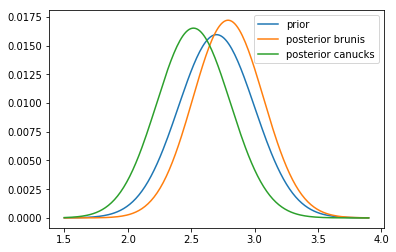

Bruins 隊的最可能的平均得分： 2.7960000000000003
Canucks 隊的最可能的平均得分： 2.5200000000000005


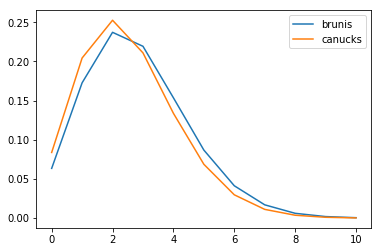

下場比賽 bruins 對得分的期望值： 2.7935105359143235
下場比賽 canucks 對得分的期望值： 2.520302000470636

棕熊隊獲勝機率： 0.45844446316038273
棕熊隊敗北機率： 0.3669275955184779
棕熊隊平手機率： 0.1746279413211396
機率和： 1.0000000000000002


In [43]:
import math
import thinkbayes as tb
import matplotlib.pyplot as plt
import numpy as np

class Hockey(tb.Suite):

    def __init__(self, name):
        # 先驗分佈為高斯分佈
        # 平均值 2.7
        # 標準差 0.3
        # 平均值上下各 4 個標準差
        pmf = tb.MakeGaussianPmf(2.7, 0.3, 4)
        tb.Suite.__init__(self, pmf)
        
        self.name = name
        
    def Likelihood(self, data, hypo):
        lam = hypo
        k = data
        like = tb.EvalPoissonPmf(k, lam)
        return like

def plot_dist(dist):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y)


def make_likelihood_dist(data, suite):
    pmf = tb.Pmf()
    for lam, _ in suite.Items():
        pmf.Set(lam, suite.Likelihood(data, lam))
    
    pmf.Normalize()
    return pmf


suite1 = Hockey('bruins')
plot_dist(suite1)
suite1.UpdateSet([0, 2, 8, 4])
suite2 = Hockey('canucks')
suite2.UpdateSet([1, 3, 1, 0])

plot_dist(suite1)
plot_dist(suite2)
plt.legend(["prior", "posterior brunis", "posterior canucks"])
plt.show()

print("Bruins 隊的最可能的平均得分：", suite1.MaximumLikelihood())
print("Canucks 隊的最可能的平均得分：", suite2.MaximumLikelihood()) 

def MakeMixture(pmf):
    mix = tb.Pmf()
    for sub_pmf, weight in pmf.Items():
        for v, prob in sub_pmf.Items():
            mix.Incr(v, weight*prob)
    
    mix.Normalize()
    return mix



def MakePoissonPmf(lam, high):
    pmf = tb.Pmf()
    for i in range(high+1):
        pmf.Set(i, tb.EvalPoissonPmf(i, lam))
    
    pmf.Normalize()
    return pmf


def MakeGoalPmf(suite, high=10):
    # suite: 後驗分佈
    meta_pmf = tb.Pmf()
    for lam, prob in suite.Items():
        pmf = MakePoissonPmf(lam, high)
        meta_pmf.Set(pmf, prob)
    
    mix = MakeMixture(meta_pmf)
    return mix

        
bruins_goal_pmf = MakeGoalPmf(suite1)
canucks_goal_pmf = MakeGoalPmf(suite2)

plot_dist(bruins_goal_pmf)
plot_dist(canucks_goal_pmf)
plt.legend(["brunis", "canucks"])
plt.show()

print("下場比賽 bruins 對得分的期望值：", bruins_goal_pmf.Mean())
print("下場比賽 canucks 對得分的期望值：", canucks_goal_pmf.Mean())


diff_pmf = bruins_goal_pmf - canucks_goal_pmf
p_win = diff_pmf.ProbGreater(0)
p_tie = diff_pmf.Prob(0)
p_loss = diff_pmf.ProbLess(0)

print()
print("棕熊隊獲勝機率：", p_win)
print("棕熊隊敗北機率：", p_loss)
print("棕熊隊平手機率：", p_tie)

print("機率和：", p_win+p_tie+p_loss)

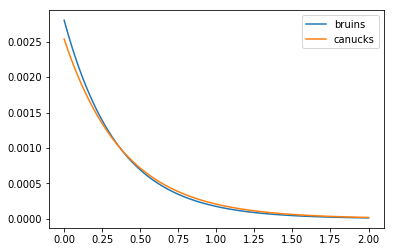

In [48]:
def EvalExponentialPdf(x, lam):
    return lam*math.exp(-lam*x)


def MakeExponentialPmf(lam, high, n=101):
    pmf = tb.Pmf()
    for x in np.linspace(0, high, n):
        density = EvalExponentialPdf(x, lam)
        pmf.Set(x, density)
    
    pmf.Normalize()
    return pmf
    
    
def MakeGoalTimePmf(suite):
    meta_pmf = tb.Pmf()
    for lam, prob, in suite.Items():
        pmf = MakeExponentialPmf(lam, high=2, n=2001)
        meta_pmf.Set(pmf, prob)
    
    mix = MakeMixture(meta_pmf)
    return mix

bruins_time_dist = MakeGoalTimePmf(suite1)
canucks_time_dist = MakeGoalTimePmf(suite2)

plot_dist(bruins_time_dist)
plot_dist(canucks_time_dist)
plt.legend(["bruins","canucks"])
plt.show()

上圖顯示各隊得1分的時間長度機率分佈。這邊的時間長度單位是場數（例如 0.3 場）。在大約 1/3 場數的時候，棕熊隊更有可能得分。直到加人隊可能的得分時間需要長一些。

這邊設定 n=2001，相當大是為了減少平手，因為兩支球隊不可能同時得分。

接下來我們計算棕熊隊先得分的機率：

<pre>
time_dist1 = MakeGoalTimePmf(suite1)
time_dist2 = MakeGoalTimePmf(suite2)
p_overtime = thinkbayes.PmfProbLess(time_dist1, time_dist2)
</pre>

In [45]:
p_overtime = tb.PmfProbLess(bruins_time_dist, canucks_time_dist)
print("棕熊隊驟死賽先得分的機率：", p_overtime)

棕熊隊驟死賽先得分的機率： 0.5241042376724302


最後，將前面的資訊整合起來，起算下一場棕熊贏的機率，包括兩個情況：

1. 棕熊隊常規比賽獲勝的機率
1. 兩隊平手下，棕熊隊驟死賽獲勝的機率

<pre>
p_tie = diff.Prob(0)
p_overtime = thinkbayes.PmfProbLess(time_dist1, time_dist2)
p_win = diff.ProbGreater(0) + p_tie * p_overtime
</pre>

對棕熊隊來說，下場比賽整體獲勝的機率接近 55%。

In [46]:
p_win = diff_pmf.ProbGreater(0) + p_tie*p_overtime
print("棕熊隊預測下一場獲勝的機率：", p_win)

棕熊隊預測下一場獲勝的機率： 0.5499677072228044


棕熊隊要贏得整個系列賽，由於還需要兩個勝場，需要考慮以下情況：

1. 第 5, 6 場連勝
2. 第 5, 6 場一勝一負且第 7 場勝

所以棕熊隊贏得系列賽的機率約為：

In [47]:
# 第 5, 6 場連勝
p_series = p_win**2
# 第 5, 6 場一勝一負且第 7 場勝
p_series += 2 * p_win * (1-p_win) * p_win
print("棕熊隊贏得系列賽的機率：", p_series)

棕熊隊贏得系列賽的機率： 0.5747020449130849


棕熊隊贏得系列賽的機率約為 57%。在 2011 年，他們做到了。